In [22]:
# Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from toolbox.ts_clustering import ts_clustering
from toolbox.figures import set_matplotlib_style, set_dtu_colors
from toolbox.ts_clustering import apply_pca_timeseries
from sklearn.decomposition import PCA
set_matplotlib_style()
colors = set_dtu_colors()

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Set up filter boundaries for the data
# Change these values for the summer period if comparing with summer measurements
periods = [['2023-01-01 00:00:00', '2023-01-31 00:00:00'], ['2023-12-01 00:00:00', '2023-12-31 00:00:00']]
# periods=[['2023-01-01 00:00:00', '2023-01-07 23:00:00']]

n_clusters = 2

In [3]:
directory = '../results/simulations/'
files = os.listdir(directory)
# Keep only the files containing simulation_data
files = [file for file in files if 'simulation_data' in file]
# Select the files starting with present-day
files = [file for file in files if 'present-day' in file]

# Import the simulation data
simulation_data = {}
cluster_labels_dict = {}
pca_data = {}
centroids = {}

for key in files:
    scenario = key.split('_')[0]
    simulation_data[scenario] = pd.read_csv(directory + key, index_col=0)
    simulation_data[scenario]['Datetime'] = pd.to_datetime(simulation_data[scenario]['Datetime'])
    filtered_data = pd.DataFrame()
    for period in periods: # Assuming periods is your list of periods
        start_date = pd.to_datetime(period[0])
        end_date = pd.to_datetime(period[1])
        period_data = simulation_data[scenario][(simulation_data[scenario]['Datetime'] >= start_date) & (simulation_data[scenario]['Datetime'] <= end_date)]
        filtered_data = pd.concat([filtered_data, period_data])
    simulation_data[scenario] = filtered_data
    
    cluster_labels_dict[scenario], pca_data[scenario], centroids[scenario] = ts_clustering(simulation_data[scenario], n_clusters=n_clusters, plot=True, scenario=scenario, method='kmeans')


(440, 1442, 2)
Estimated time: 477.64371967315674 seconds


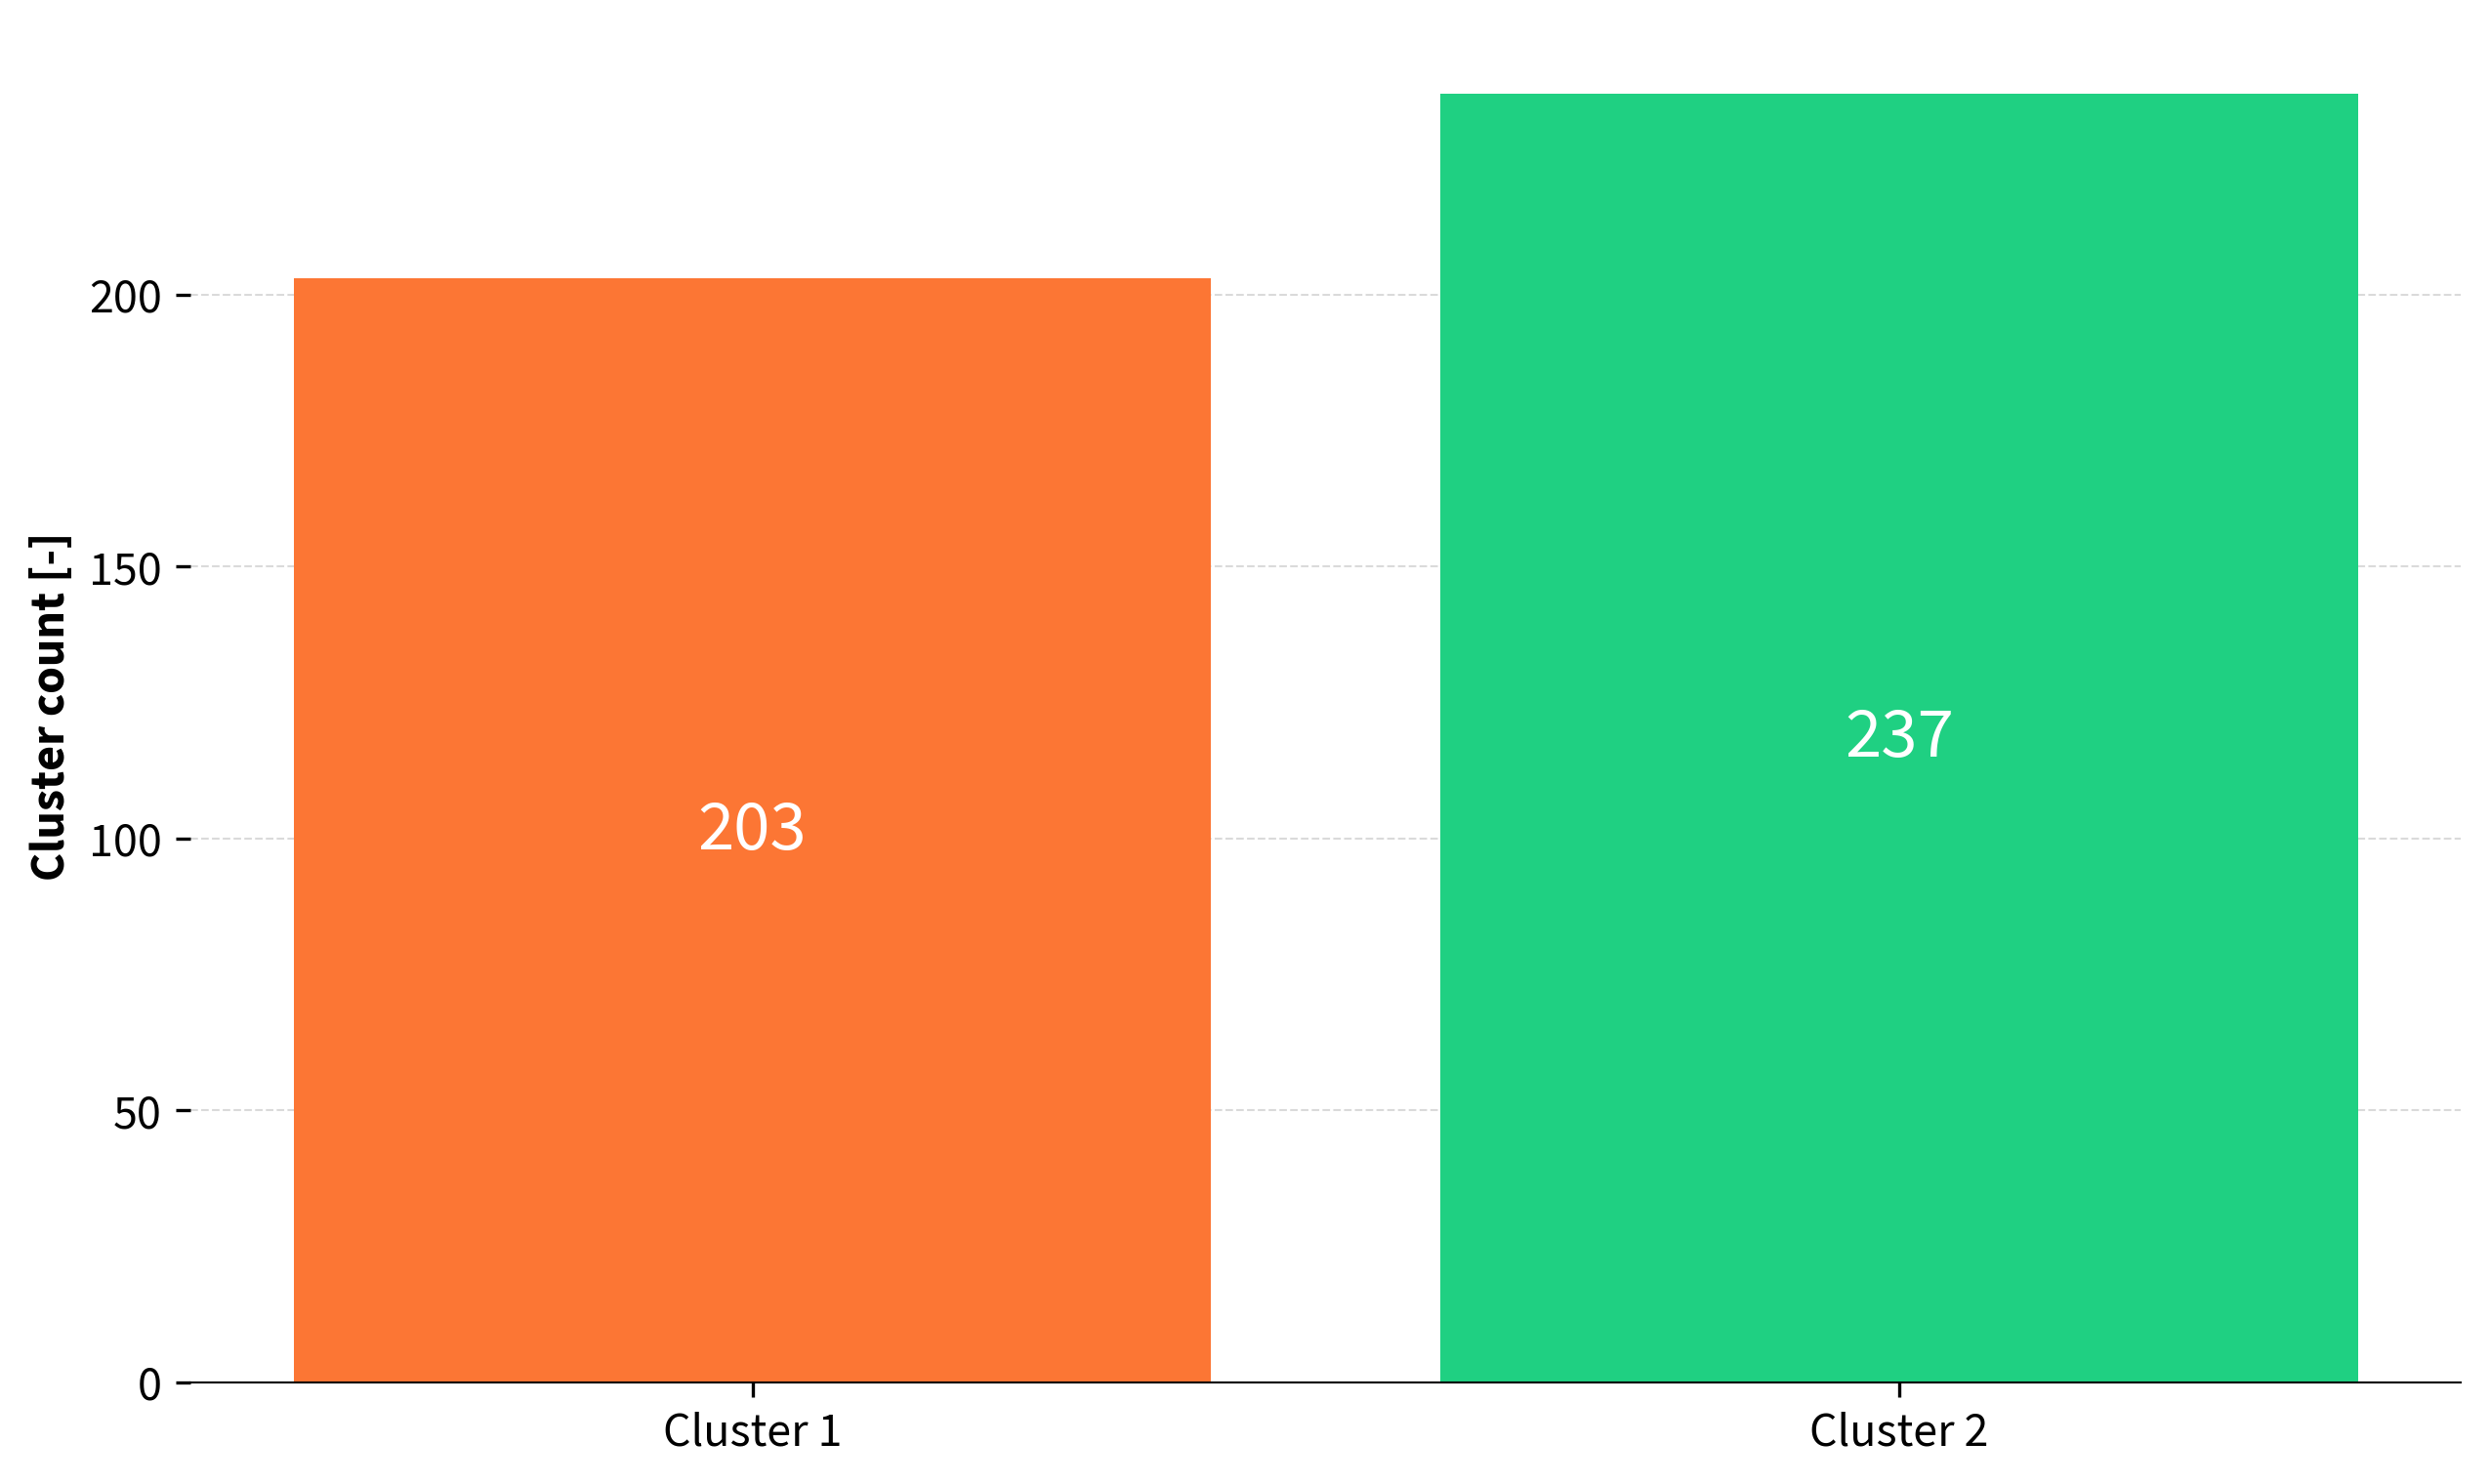

In [4]:
# Plot distribution of cluster labels
# Choose randomly n_clusters colors out of the DTU color palette
colors_list = list(colors.values())
color = np.random.choice(colors_list, n_clusters, replace=False)
for key in cluster_labels_dict.keys():
    cluster_count = len(cluster_labels_dict[key]['cluster'].unique())
    cluster_c = [len(cluster_labels_dict[key]['cluster'][cluster_labels_dict[key]['cluster']==i]) for i in range(cluster_count)]
    cluster_n = ["Cluster "+str(i+1) for i in range(cluster_count)]
    
    plt.figure(figsize=(10,6))
    plt.bar(cluster_n,cluster_c, color=color)
    for i in range(cluster_count):
        plt.text(i,cluster_c[i]-cluster_c[i]/2,cluster_c[i],ha='center',va='center', fontsize=18, color='w')
    plt.ylabel('Cluster count [-]')
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.xaxis.grid(False)
    # plt.title('[{}] Cluster distribution'.format(key))
    # Save figure
    plt.savefig('../figures/data_augmentation/cluster_distribution_{}.png'.format(key), dpi=300, bbox_inches='tight')
    plt.show()

In [1]:
# Import measurements data
paths = ['../database/cleaned/johannesburg_concatenated.csv', '../database/cleaned/giyani_summer_concatenated.csv', '../database/cleaned/giyani_winter_concatenated.csv']
# paths = ['../database/cleaned/johannesburg_concatenated.csv']
pca_measurements_data = {}
measurements_cluster_labels = {}
measurements_centroids = {}
for path in paths:
    location = path.split('/')[3].split('_')[0]
    # Use ts_clustering function to cluster the measurements data
    df = pd.read_csv(path, index_col=0)
    df_dict = dict(tuple(df.groupby('key')))
    for key in df_dict.keys():
        # Keep only the data in the month of March
        df_dict[key]['Datetime'] = pd.to_datetime(df_dict[key]['Datetime'])
        # Summer measurements (December, January, February, March)
        df_dict[key] = df_dict[key][df_dict[key]['Datetime'].dt.month.isin([12,1,2,3])]
    try:
        measurements_cluster_labels[location], pca_measurements_data[location], measurements_centroids[location] = ts_clustering(df_dict, n_clusters=n_clusters, plot=True, scenario=location, method='kmeans')
    except:
        continue

NameError: name 'pd' is not defined

In [6]:
# Assuming you have your time series data stored in the variable 'time_series_data'
# Apply PCA to the time series data
pca_data_transformed = {}
for key in pca_data.keys():
    reshaped_pca_data = np.array(pca_data[key])
    pca = PCA(n_components=2)
    pca.fit(reshaped_pca_data)
    pca_data_transformed[key] = pca.transform(reshaped_pca_data)

pca_measurements_data_transformed = {}
for key in pca_measurements_data.keys():
    reshaped_pca_data = np.array(pca_measurements_data[key])
    pca = PCA(n_components=2)
    pca.fit(reshaped_pca_data)
    pca_measurements_data_transformed[key] = pca.transform(reshaped_pca_data)

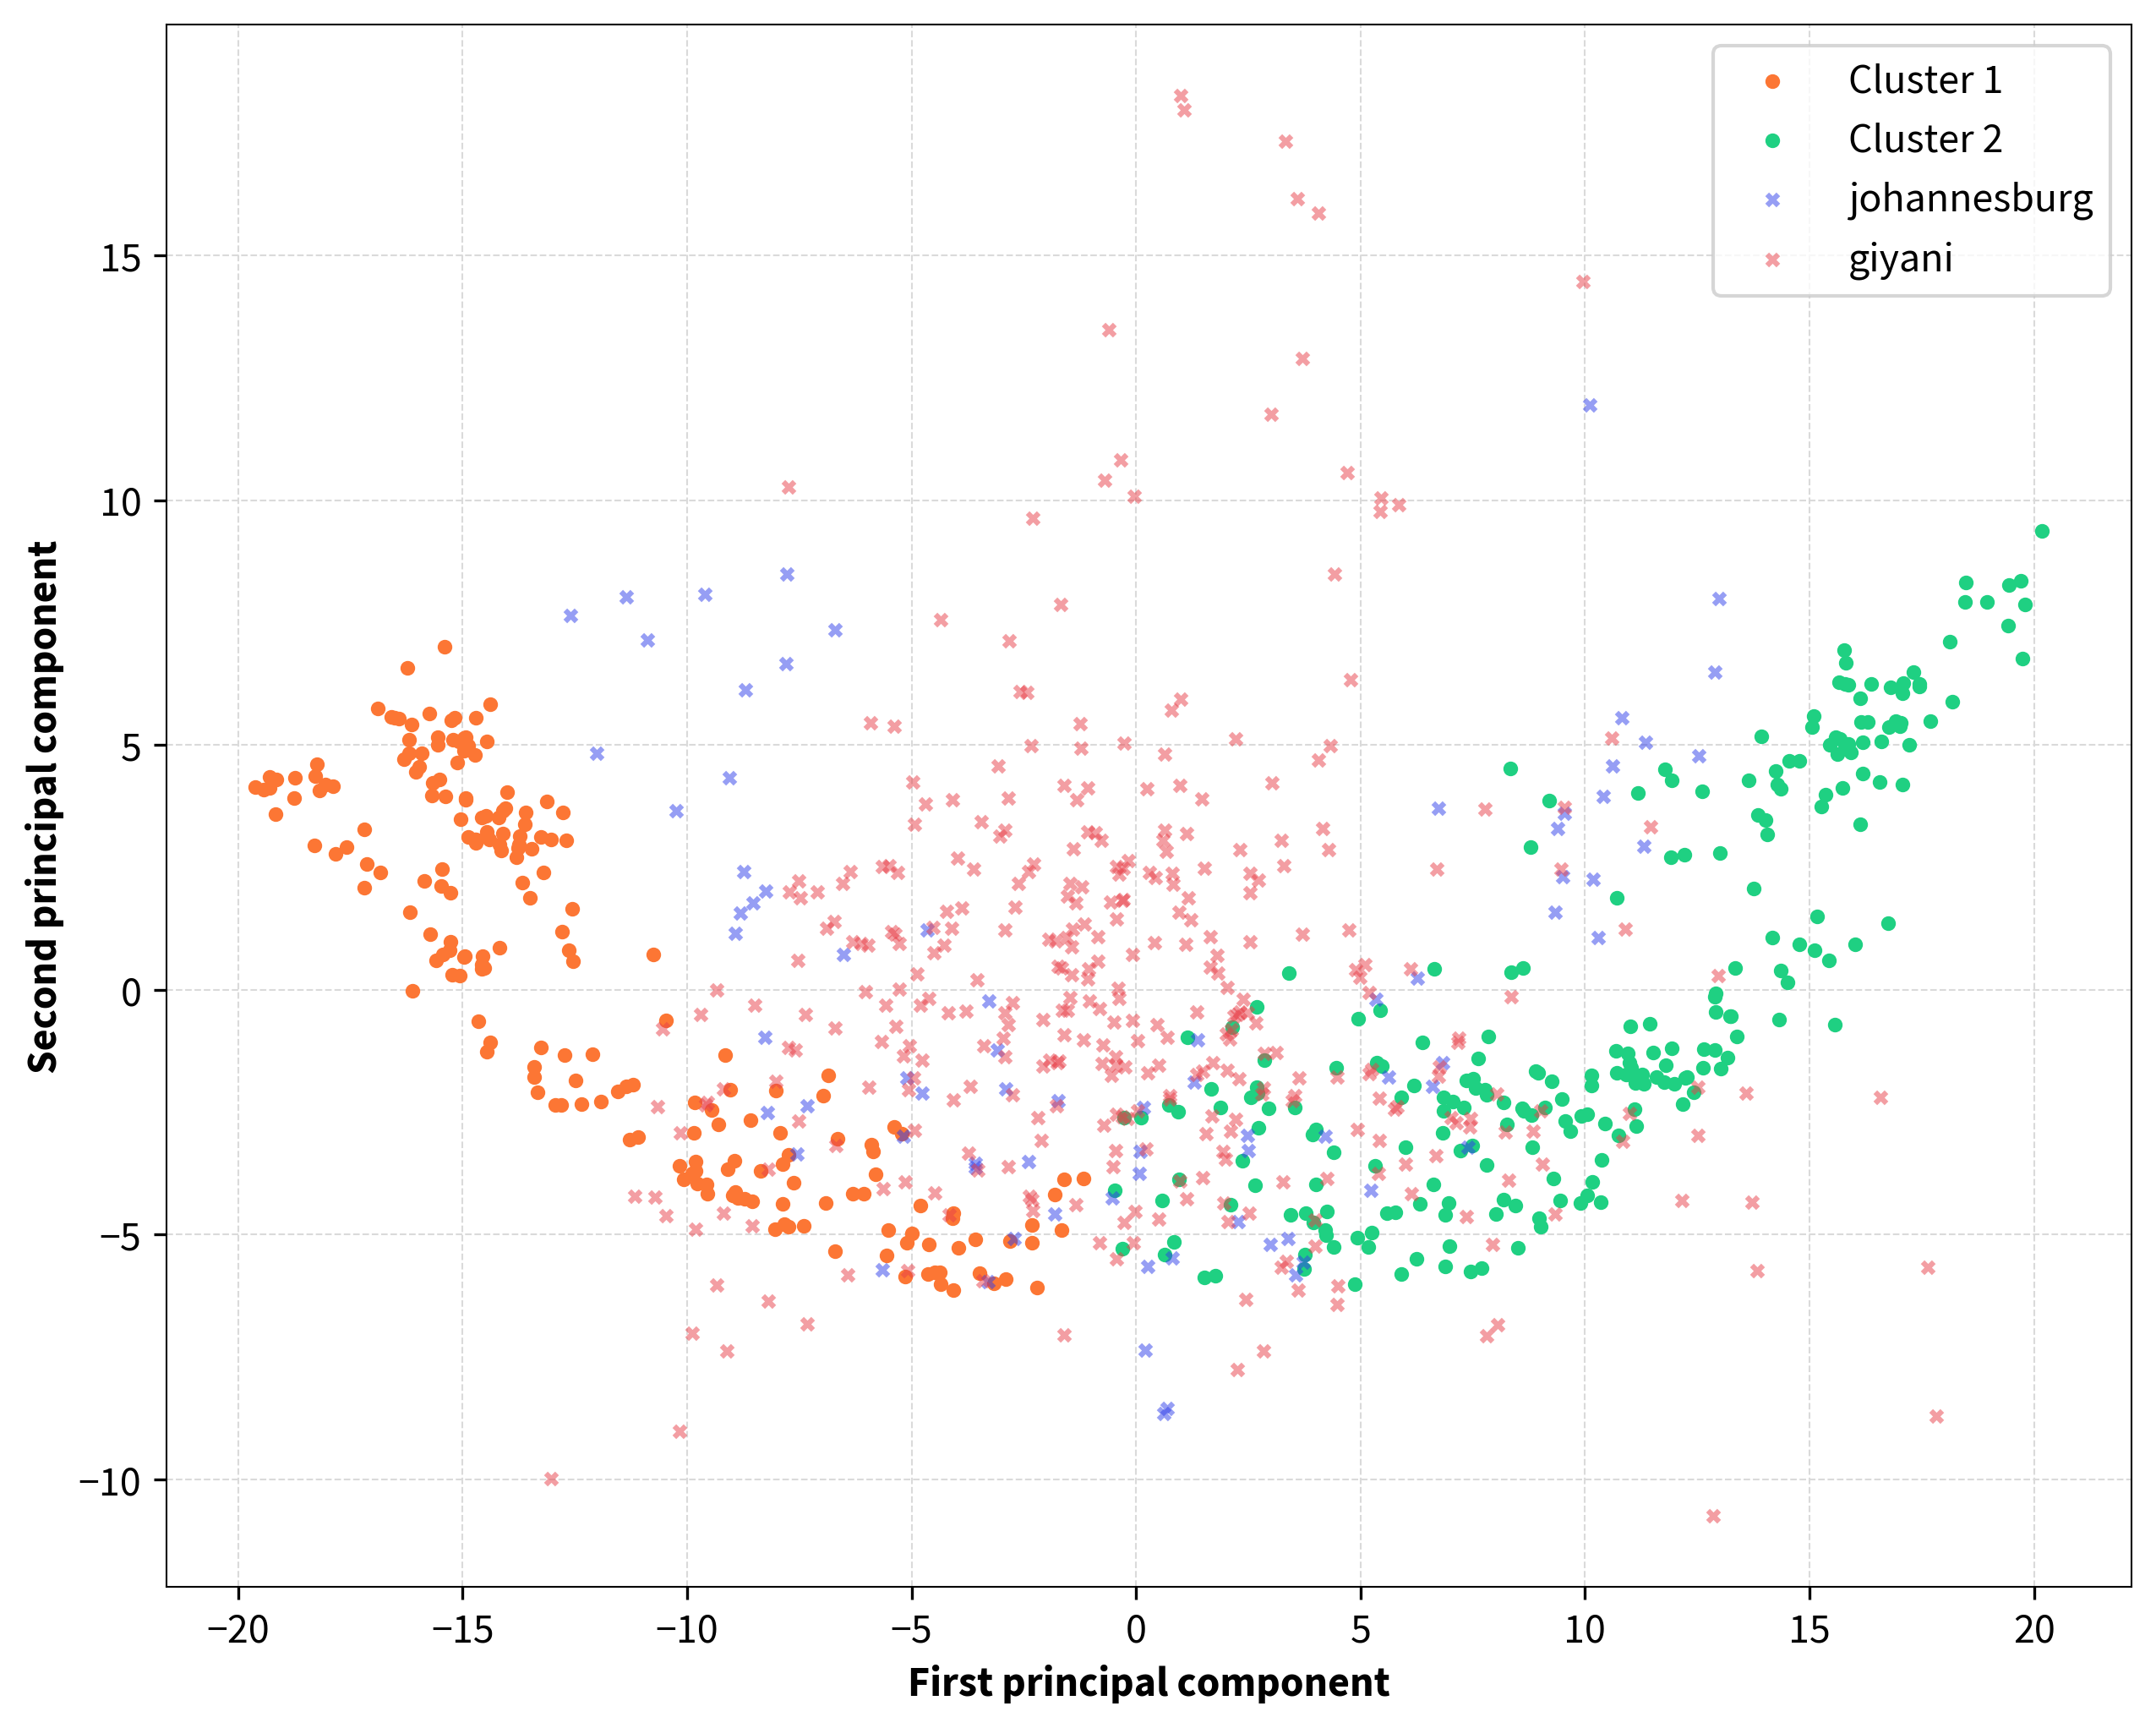

In [7]:
#%% Plot the clusters in the PCA space
for key in pca_data_transformed.keys():
    cluster_count = len(cluster_labels_dict[key]['cluster'].unique())
    cluster_labels = cluster_labels_dict[key]['cluster']

    plt.figure()
    # Plot the points
    for i in range(cluster_count):
        plt.scatter(pca_data_transformed[key][cluster_labels == i, 0], pca_data_transformed[key][cluster_labels == i, 1], c=color[i], label='Cluster ' + str(i+1), s=10, marker='o')
    # Plot the measurements data
    for i, location in enumerate(pca_measurements_data_transformed.keys()):
        plt.scatter(pca_measurements_data_transformed[location][:, 0], pca_measurements_data_transformed[location][:, 1], c=[colors['dtu_blue'], colors['dtu_red']][i], label=location, s=10, marker='x', alpha=0.5)

    # Plot 

    plt.xlabel('First principal component')
    plt.ylabel('Second principal component')
    # plt.title('[{}] PCA two-dimensional projection'.format(key))
    ax = plt.gca()
    plt.legend()
    # Set a frame around the legend
    leg = ax.get_legend()
    leg.set_frame_on(True)
    # Save the figure
    plt.savefig('../figures/data_augmentation/PCA_2D_projection_{}.png'.format(key), dpi=300)
    plt.show()


In [44]:
n_clusters = 5
# Import measurements data
paths = ['../database/cleaned/johannesburg_concatenated.csv']
pca_measurements_data = {}
measurements_cluster_labels = {}
measurements_centroids = {}
for path in paths:
    location = path.split('/')[3].split('_')[0]
    # Use ts_clustering function to cluster the measurements data
    df = pd.read_csv(path, index_col=0)
    df_dict = dict(tuple(df.groupby('key')))
    for key in df_dict.keys():
        # Keep only the data in the month of March
        df_dict[key]['Datetime'] = pd.to_datetime(df_dict[key]['Datetime'])
        # Summer measurements (December, January, February, March)
        df_dict[key] = df_dict[key][df_dict[key]['Datetime'].dt.month.isin([12,1,2,3])]
    try:
        measurements_cluster_labels[location], pca_measurements_data[location], measurements_centroids[location] = ts_clustering(df_dict, n_clusters=n_clusters, plot=True, scenario=location, method='kmeans')
    except:
        continue

(78, 1003, 2)
Estimated time: 59.32383155822754 seconds


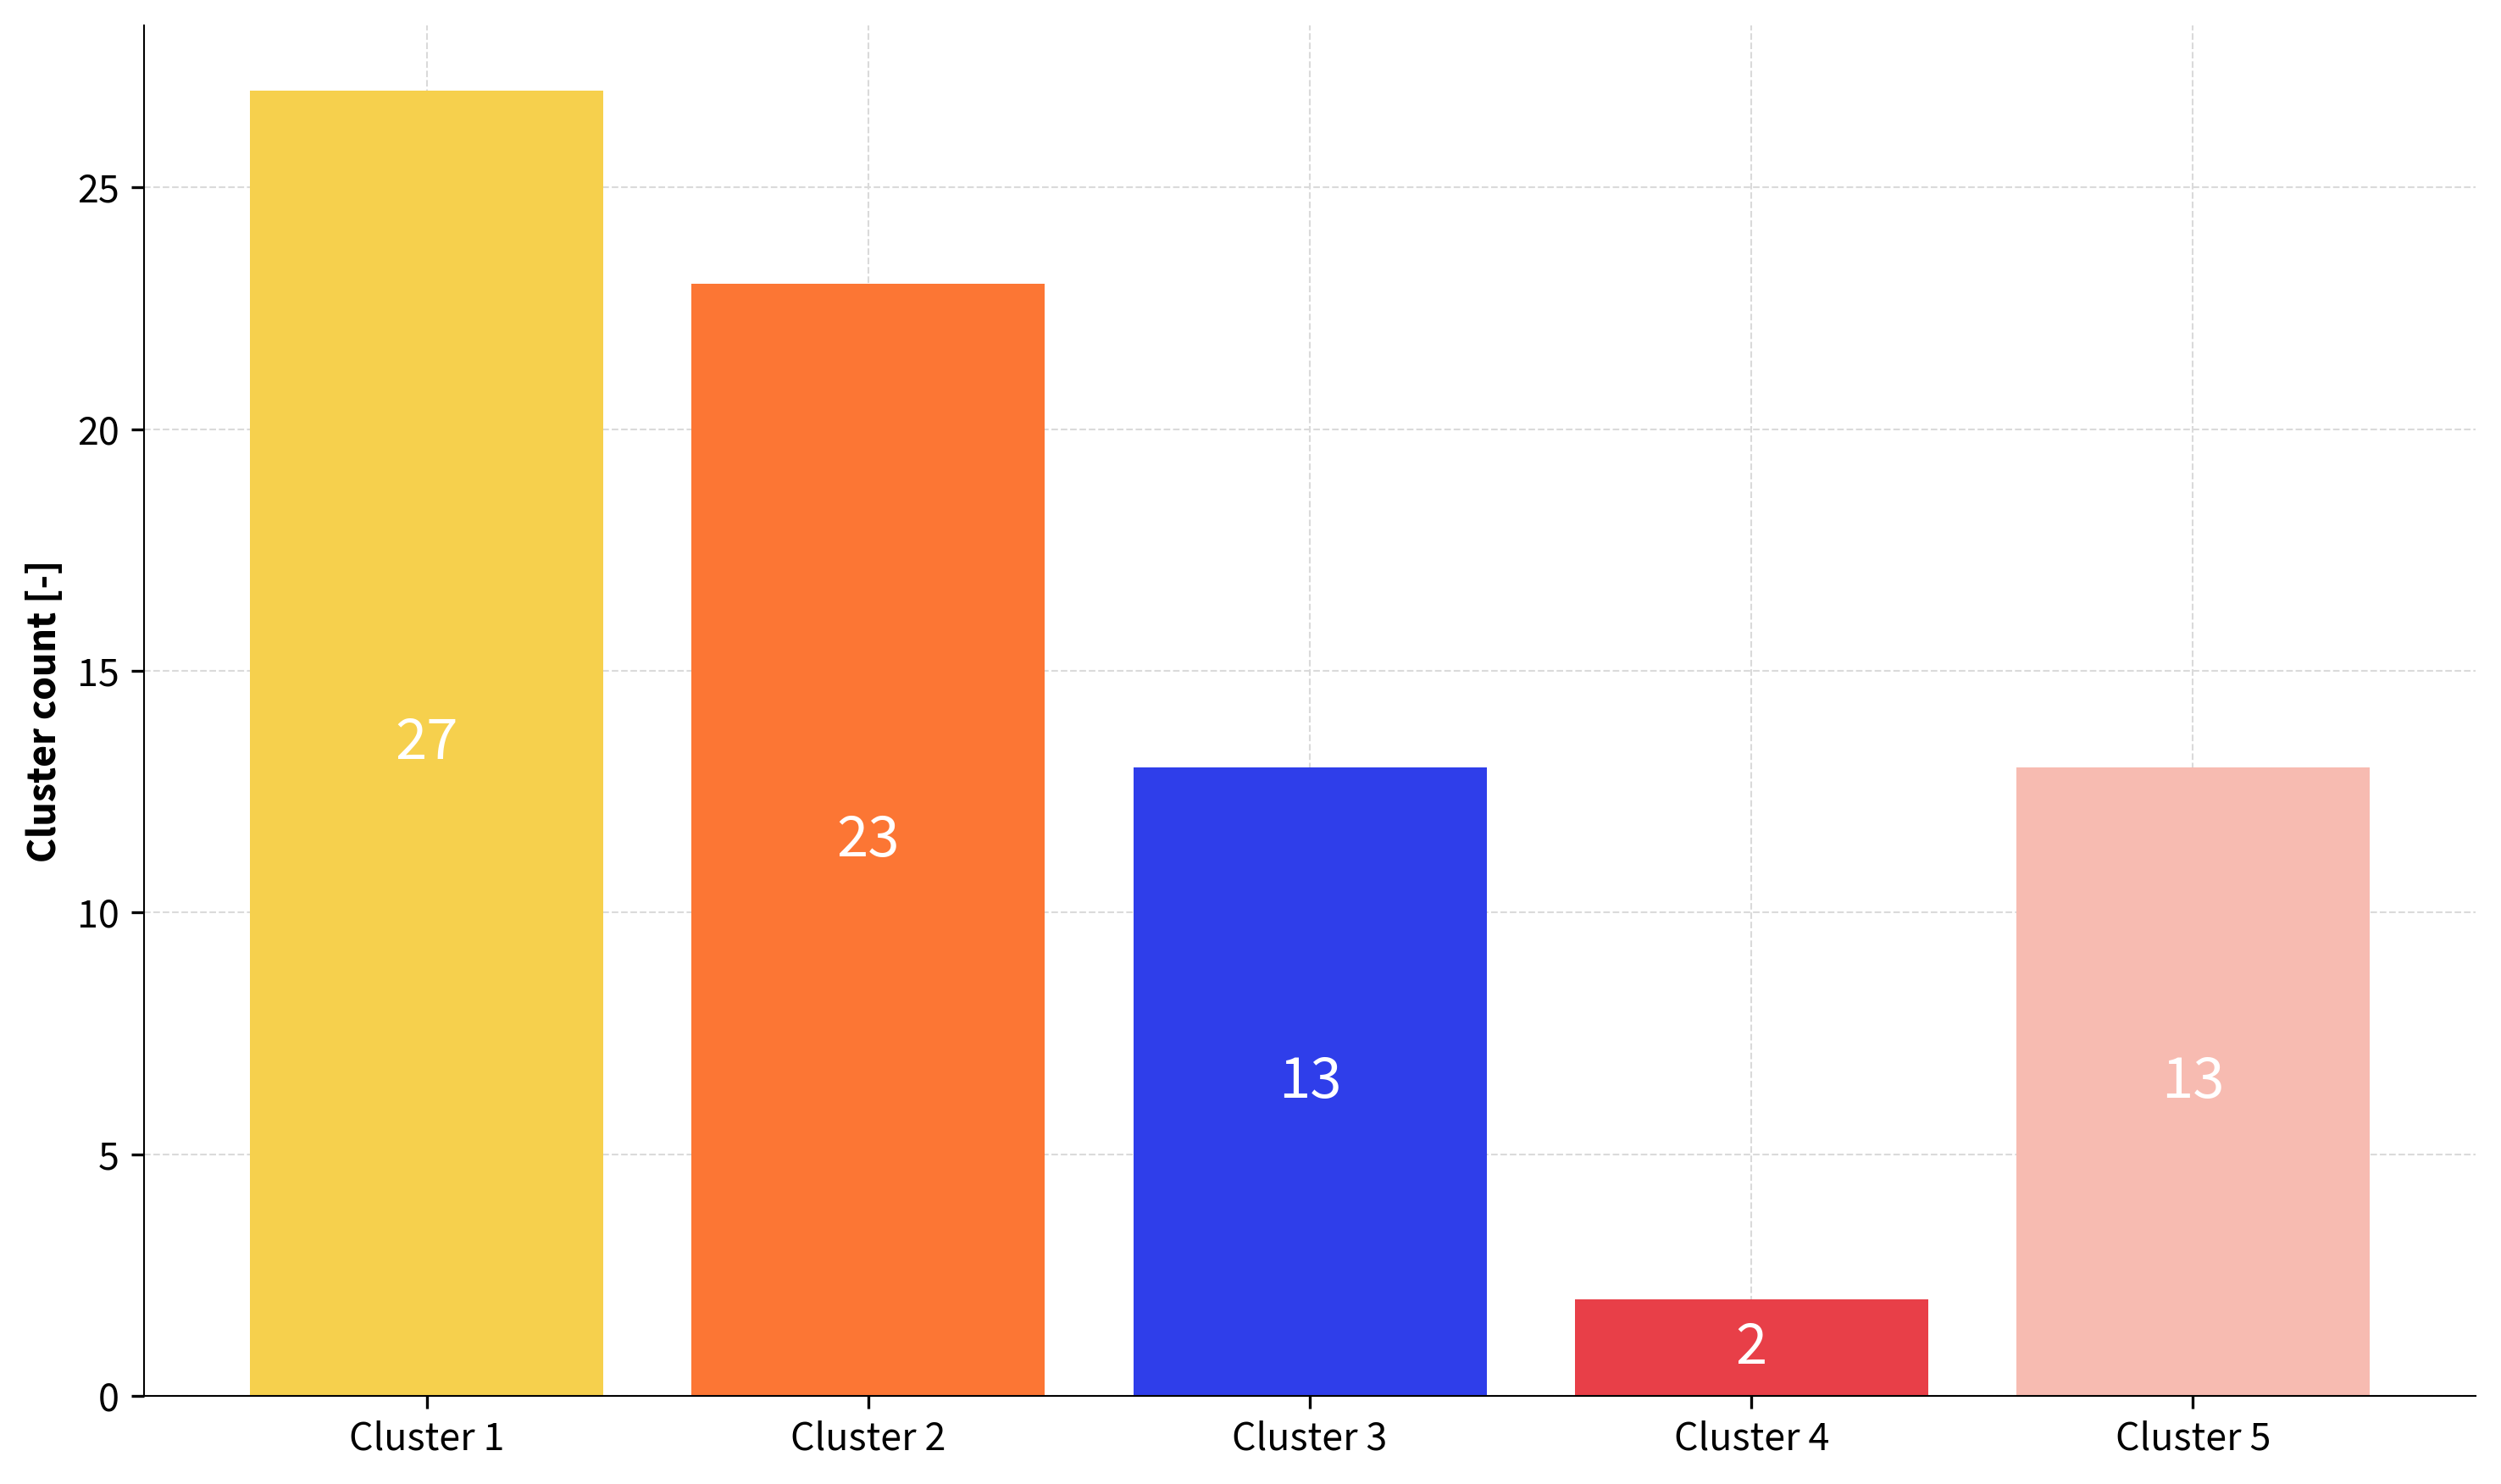

In [48]:
# Plot distribution of cluster labels
# Choose randomly n_clusters colors out of the DTU color palette
colors_list = list(colors.values())
color = np.random.choice(colors_list, n_clusters, replace=False)

for key in measurements_cluster_labels.keys():
    cluster_count = len(measurements_cluster_labels[key]['cluster'].unique())
    cluster_c = [len(measurements_cluster_labels[key]['cluster'][measurements_cluster_labels[key]['cluster']==i]) for i in range(cluster_count)]
    cluster_n = ["Cluster "+str(i+1) for i in range(cluster_count)]
    
    plt.figure(figsize=(10,6))
    plt.bar(cluster_n,cluster_c, color=color)
    for i in range(cluster_count):
        plt.text(i,cluster_c[i]-cluster_c[i]/2,cluster_c[i],ha='center',va='center', fontsize=18, color='w')
    plt.ylabel('Cluster count [-]')
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # plt.title('[{}] Cluster distribution'.format(key))
    plt.tight_layout()
    plt.savefig('../figures/data_augmentation/cluster_distribution_{}.png'.format(key), dpi=300)
    plt.show()
# Assuming you have your time series data stored in the variable 'time_series_data'
# Apply PCA to the time series data

pca_measurements_data_transformed = {}
for key in pca_measurements_data.keys():
    reshaped_pca_data = np.array(pca_measurements_data[key])
    pca = PCA(n_components=2)
    pca.fit(reshaped_pca_data)
    pca_measurements_data_transformed[key] = pca.transform(reshaped_pca_data)


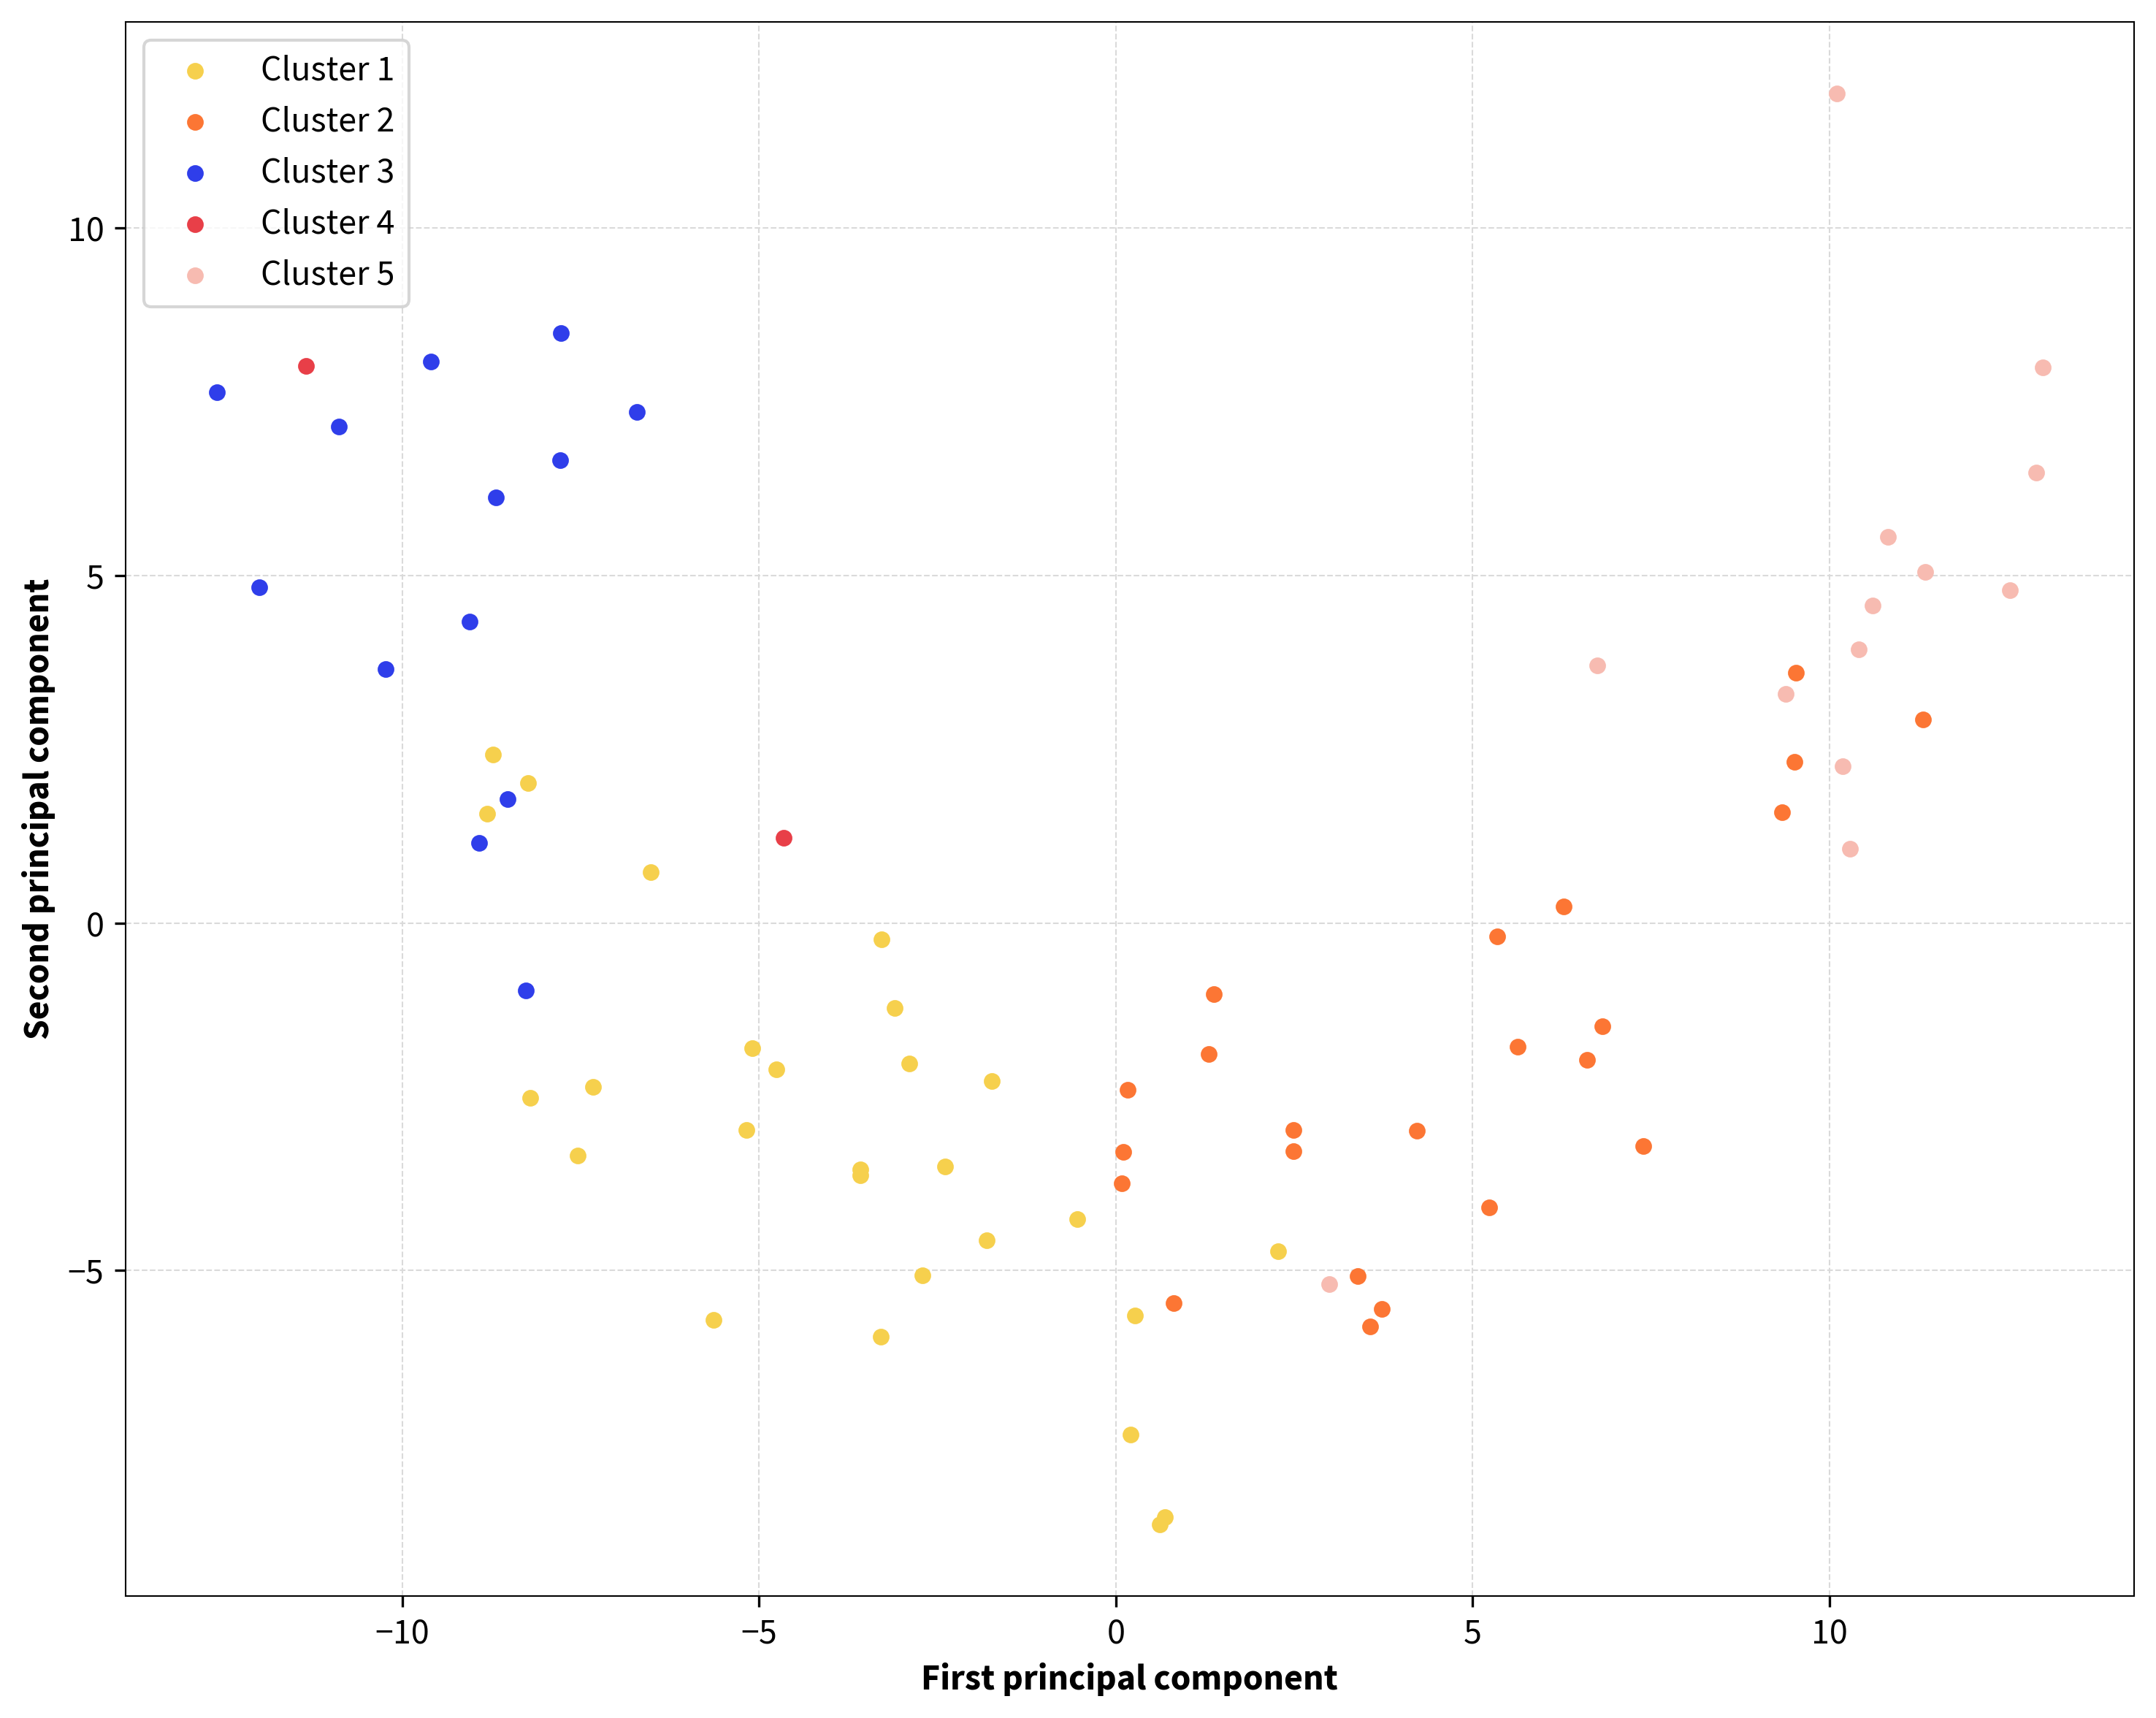

In [49]:
#%% Plot the clusters in the PCA space for the measurements data
for key in pca_measurements_data_transformed.keys():
    cluster_count = len(measurements_cluster_labels[key]['cluster'].unique())
    cluster_labels = measurements_cluster_labels[key]['cluster']

    plt.figure()
    # Plot the points
    for i in range(cluster_count):
        plt.scatter(pca_measurements_data_transformed[key][cluster_labels == i, 0], pca_measurements_data_transformed[key][cluster_labels == i, 1], c=color[i], label='Cluster ' + str(i+1), s=20, marker='o')

    # Legend
    plt.legend(frameon=True, loc='upper left')
    # Plot
    plt.xlabel('First principal component')
    plt.ylabel('Second principal component')
    # plt.title('[{}] PCA
    plt.tight_layout()
    plt.savefig('../figures/data_augmentation/PCA_2D_projection_{}.png'.format(key), dpi=300)

In [29]:
print(key)

johannesburg


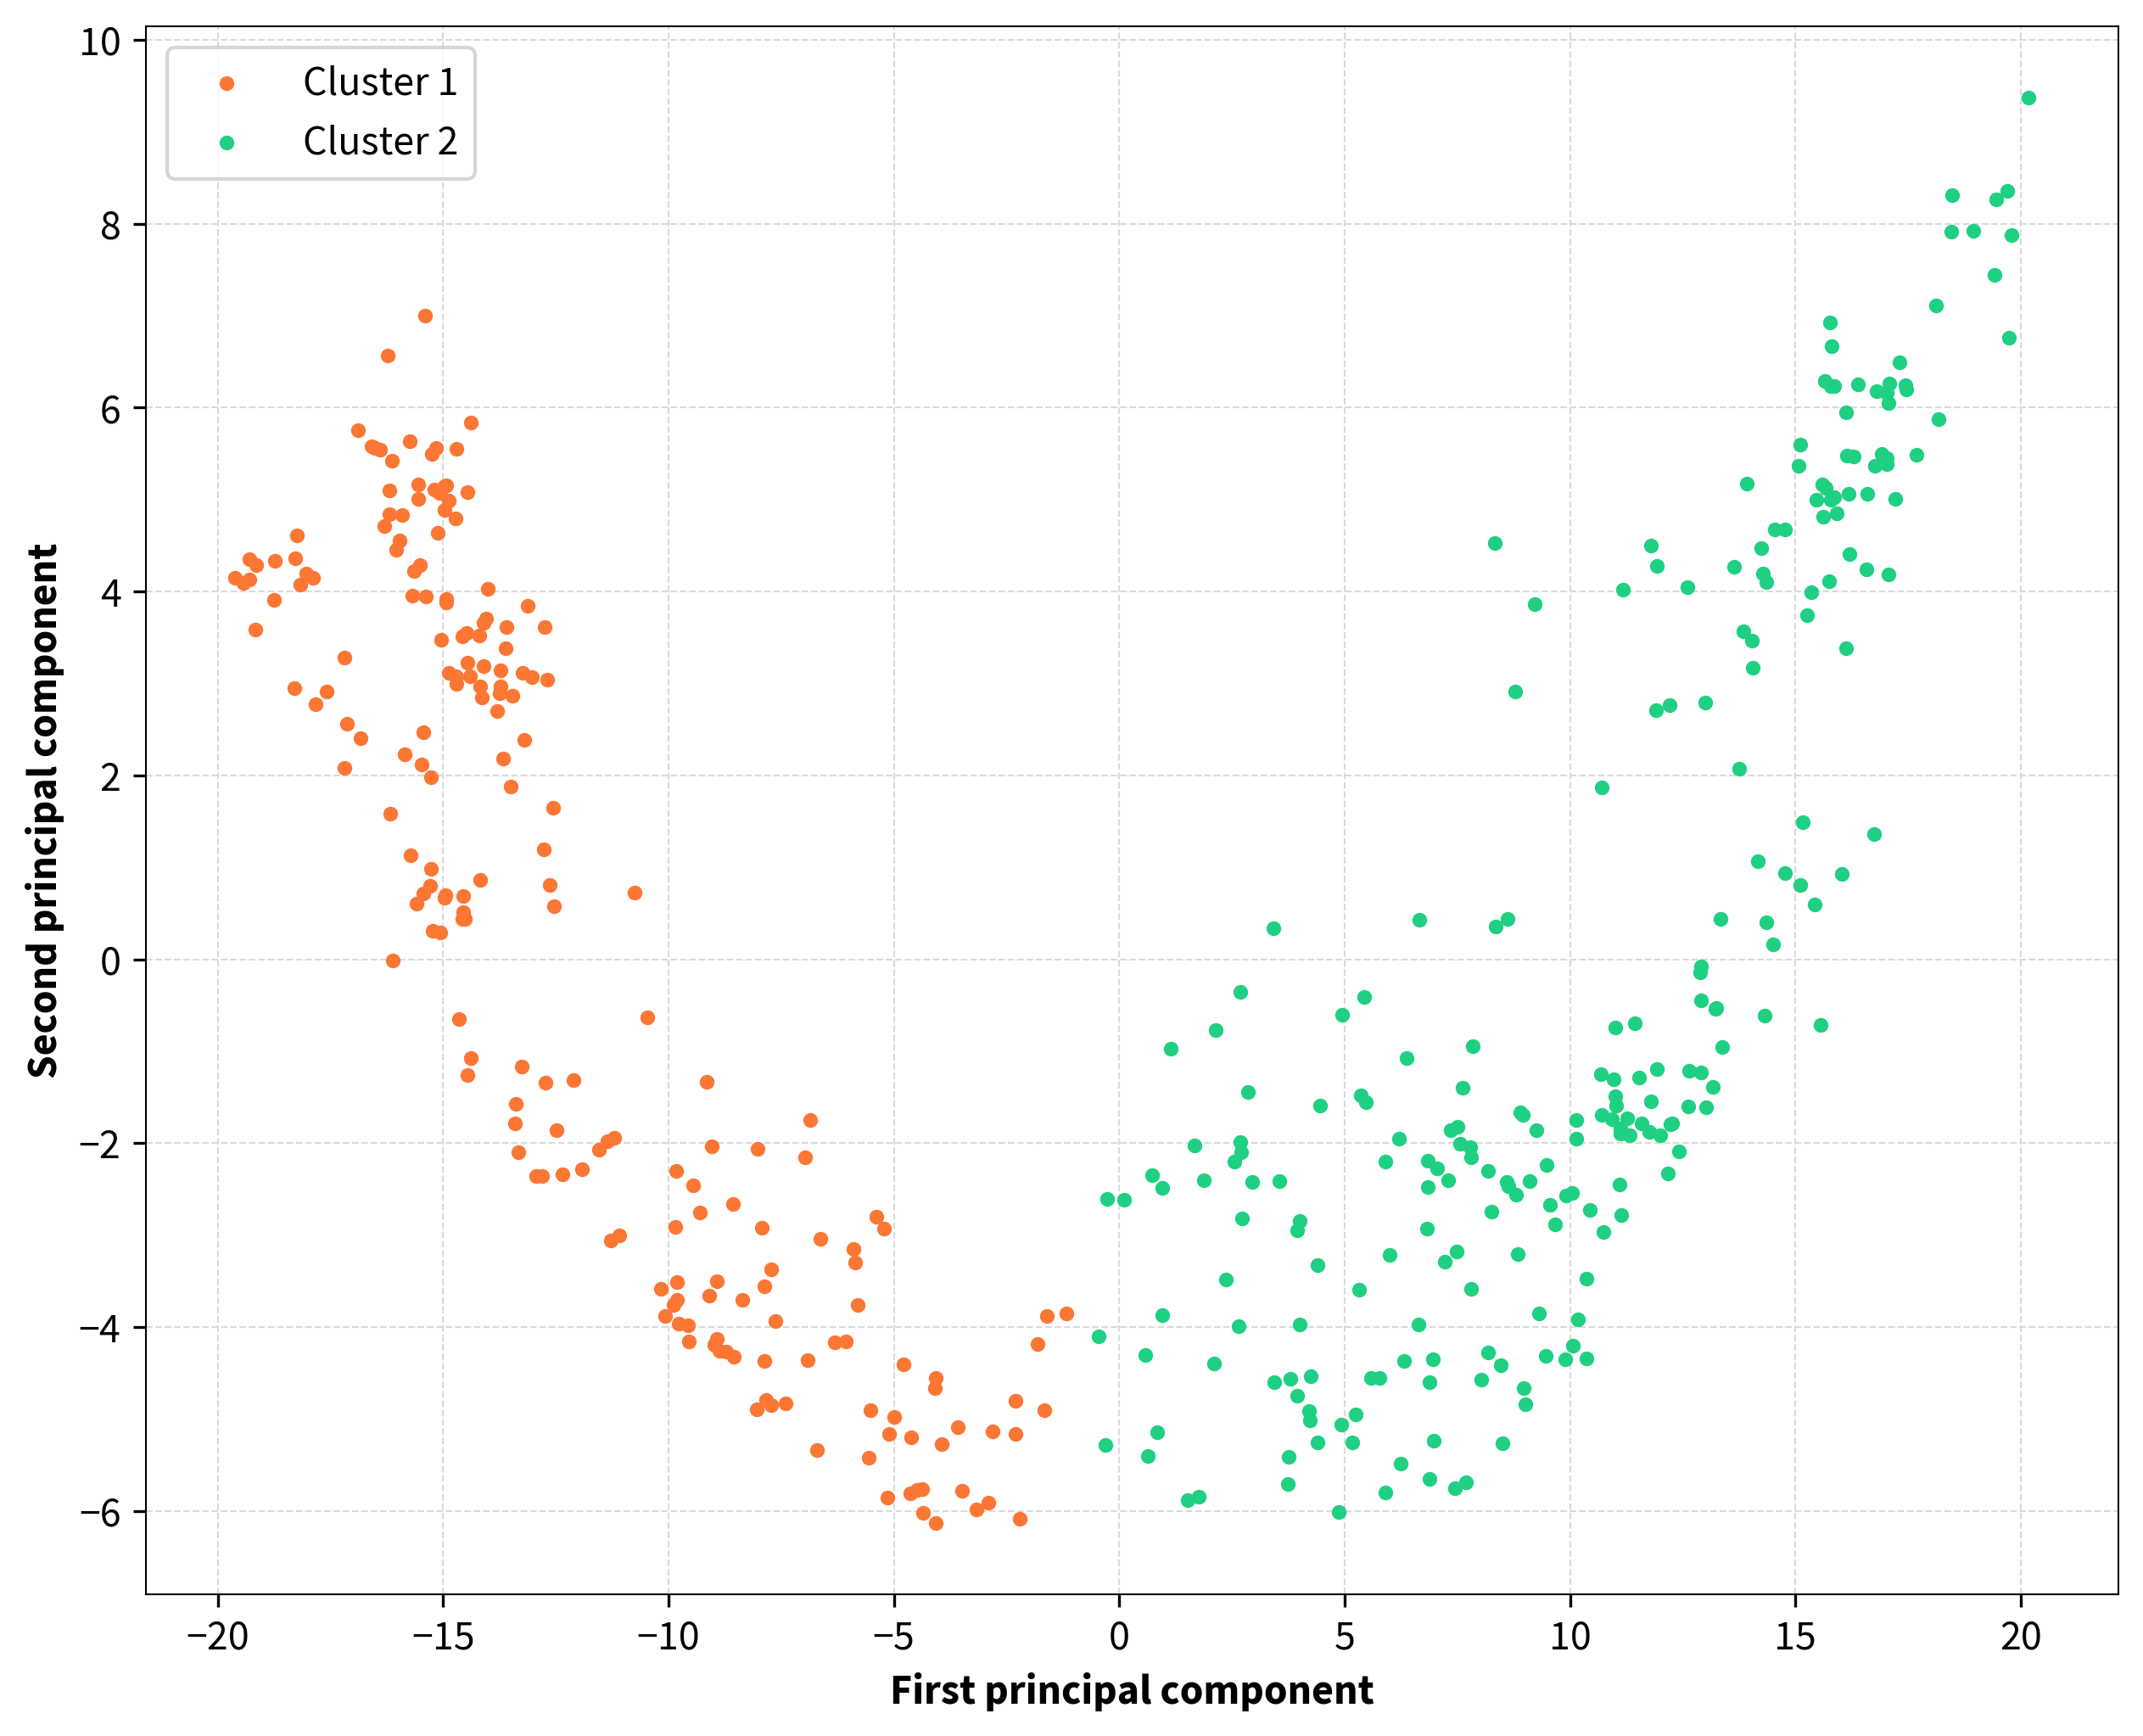

In [8]:
#%% Plot the clusters in the PCA space
for key in pca_data_transformed.keys():
    cluster_count = len(cluster_labels_dict[key]['cluster'].unique())
    cluster_labels = cluster_labels_dict[key]['cluster']

    plt.figure()
    # Plot the points
    for i in range(cluster_count):
        plt.scatter(pca_data_transformed[key][cluster_labels == i, 0], pca_data_transformed[key][cluster_labels == i, 1], c=color[i], label='Cluster ' + str(i+1), s=10, marker='o')

    # Plot 

    plt.xlabel('First principal component')
    plt.ylabel('Second principal component')
    # plt.title('[{}] PCA two-dimensional projection'.format(key))
    ax = plt.gca()
    plt.legend()
    # Set a frame around the legend
    leg = ax.get_legend()
    leg.set_frame_on(True)
    # Save the figure
    plt.savefig('../figures/data_augmentation/simulation_PCA_2D_projection_{}.png'.format(key), dpi=300)
    plt.show()


In [9]:
#%% Plot the clusters in the PCA space
for key in pca_data_transformed.keys():
    cluster_count = len(cluster_labels_dict[key]['cluster'].unique())
    cluster_labels = cluster_labels_dict[key]['cluster']

    plt.figure(figsize=(30,30))
    # Plot the points
    for i in range(cluster_count):
        plt.scatter(pca_data_transformed[key][cluster_labels == i, 0], pca_data_transformed[key][cluster_labels == i, 1], c=color[i], label='Cluster ' + str(i+1), s=30, marker='o')
    # Plot the measurements data
    for i, location in enumerate(pca_measurements_data_transformed.keys()):
        plt.scatter(pca_measurements_data_transformed[location][:, 0], pca_measurements_data_transformed[location][:, 1], c=[colors['dtu_blue'], colors['dtu_red']][i], label=location, s=30, marker='x', alpha=0.5)

    # Plot 

    ax = plt.gca()
    ax.xaxis.grid(False)
    ax.yaxis.grid(False)
    plt.legend()
    # Set a frame around the legend
    leg = ax.get_legend()
    leg.set_frame_on(True)
    
    # Set figure background color
    ax.set_facecolor(colors['dtu_grey'])
    ax.set_facecolor((1, 1, 1))

    # Save the figure
    plt.savefig('../figures/data_augmentation/front_page_{}.png'.format(key), dpi=300)
    plt.show()

In [10]:
# Export the cluster labels to a csv file
for key in cluster_labels_dict.keys():
    cluster_labels_dict[key].to_csv('../results/simulations/{}_cluster_labels.csv'.format(key))